<a href="https://colab.research.google.com/github/antussa2016/Data_mining/blob/master/fake_news_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import wordcloud as WordCloud

In [2]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPool1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import  classification_report, accuracy_score


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
fake = pd.read_csv("/content/drive/MyDrive/Fake.csv")

In [5]:
fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [6]:
fake.columns

Index(['title', 'text', 'subject', 'date'], dtype='object')

In [7]:
fake['subject'].value_counts()

News               9050
politics           6841
left-news          4459
Government News    1570
US_News             783
Middle-east         778
Name: subject, dtype: int64

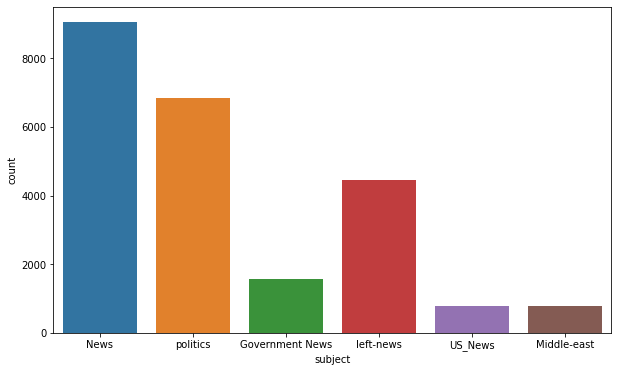

In [8]:
plt.figure(figsize=(10,6))
sns.countplot(x='subject', data=fake)

# **Wordcloud** 

In [9]:
text=' '.join(fake['text'].tolist())
type(text)

str

In [10]:
' '.join(['i','am','antu'])

'i am antu'

In [11]:
wordCloud = WordCloud.WordCloud(width=1920,height=1000).generate(text)


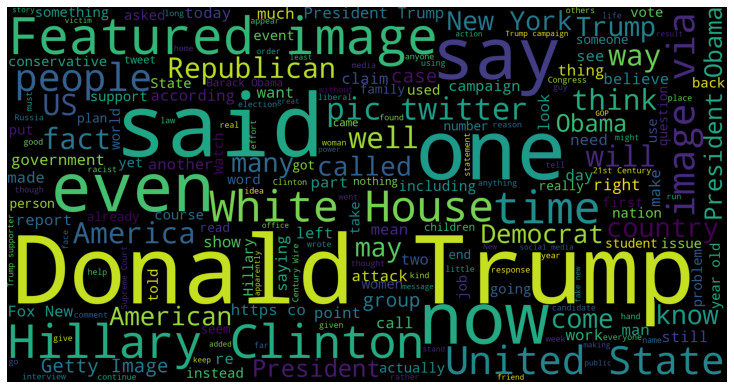

In [12]:
fig=plt.figure(figsize=(10,6))
plt.imshow(wordCloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

# Explore Real news

In [13]:
real = pd.read_csv("/content/drive/MyDrive/True.csv")
text=' '.join(real['text'].tolist())

In [14]:
wordCloud = WordCloud.WordCloud(width=1920,height=1000).generate(text)

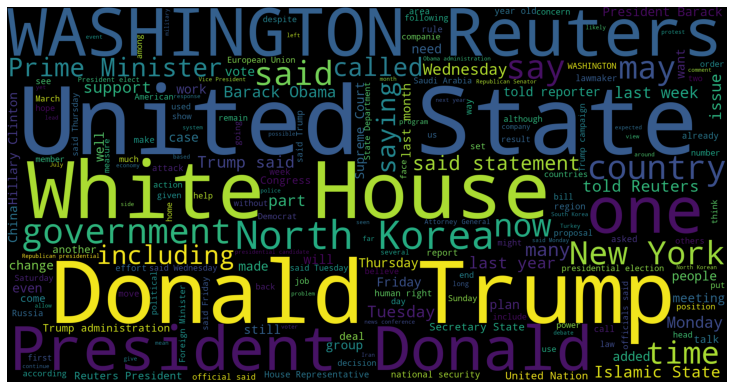

In [15]:
fig=plt.figure(figsize=(10,6))
plt.imshow(wordCloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [16]:
real.sample(5)

,title,text,subject,date
12096,Tens of thousands of Indonesians rally over Tr...,JAKARTA (Reuters) - Tens of thousands of Musli...,worldnews,"December 17, 2017"
15271,Hilltop tribe's bitterness a challenge for Lib...,"BANI WALID, Libya (Reuters) - Elders of a powe...",worldnews,"November 9, 2017"
12973,Netanyahu says Israel expanding Middle East ti...,JERUSALEM (Reuters) - Israel is expanding ties...,worldnews,"December 6, 2017"
18897,South Africa anti-Zuma protests harden ANC suc...,CAPE TOWN/JOHANNESBURG (Reuters) - Thousands o...,worldnews,"September 27, 2017"
21136,Iran sees little chance of enemy attack: milit...,DUBAI (Reuters) - - Enemies are unlikely to at...,worldnews,"September 2, 2017"


In [29]:
unknown_publishers = []
for index, row in enumerate(real.text.values):
  try:
    record = row.split('-', maxsplit=1)
    record[1]

    assert(len(record[0])<120)

  except:
    unknown_publishers.append(index)

In [30]:
len(unknown_publishers)

221

In [31]:
real.iloc[unknown_publishers].text

7        The following statements were posted to the ve...
8        The following statements were posted to the ve...
12       The following statements were posted to the ve...
13       The following statements were posted to the ve...
14        (In Dec. 25 story, in second paragraph, corre...
                               ...                        
20135     (Story corrects to million from billion in pa...
20500     (This Sept 8 story corrects headline, clarifi...
20667     (Story refiles to add dropped word  not , in ...
21246     (Story corrects third paragraph to show Mosul...
21339     (Story corrects to fix spelling in paragraph ...
Name: text, Length: 221, dtype: object

In [27]:
real.iloc[8970]

title      Graphic: Supreme Court roundup
text                                     
subject                      politicsNews
date                       June 16, 2016 
Name: 8970, dtype: object

In [28]:
real= real.drop(8970,axis=0)

In [32]:
publisher=[]
tmp_text=[]

for index, row in enumerate(real.text.values):
  if index in unknown_publishers:
    tmp_text.append(row)
    publisher.append('Unknown')
    continue
  else:
    record = row.split('-', maxsplit=1)
    publisher.append(record[0].strip())
    tmp_text.append(record[1].strip())

In [33]:
real['publisher']=publisher
real['text']=tmp_text

In [34]:
real.head()

,title,text,subject,date,publisher
0,"As U.S. budget fight looms, Republicans flip t...",The head of a conservative Republican faction ...,politicsNews,"December 31, 2017",WASHINGTON (Reuters)
1,U.S. military to accept transgender recruits o...,Transgender people will be allowed for the fir...,politicsNews,"December 29, 2017",WASHINGTON (Reuters)
2,Senior U.S. Republican senator: 'Let Mr. Muell...,The special counsel investigation of links bet...,politicsNews,"December 31, 2017",WASHINGTON (Reuters)
3,FBI Russia probe helped by Australian diplomat...,Trump campaign adviser George Papadopoulos tol...,politicsNews,"December 30, 2017",WASHINGTON (Reuters)
4,Trump wants Postal Service to charge 'much mor...,President Donald Trump called on the U.S. Post...,politicsNews,"December 29, 2017",SEATTLE/WASHINGTON (Reuters)


In [35]:
real.shape

(21416, 5)

In [39]:
empty_fake_index=[index for index, text in enumerate(fake.text.tolist()) if str(text).strip()==""]

In [40]:
fake.iloc[empty_fake_index]

,title,text,subject,date
10923,TAKE OUR POLL: Who Do You Think President Trum...,,politics,"May 10, 2017"
11041,Joe Scarborough BERATES Mika Brzezinski Over “...,,politics,"Apr 26, 2017"
11190,WATCH TUCKER CARLSON Scorch Sanctuary City May...,,politics,"Apr 6, 2017"
11225,MAYOR OF SANCTUARY CITY: Trump Trying To Make ...,,politics,"Apr 2, 2017"
11236,SHOCKER: Public School Turns Computer Lab Into...,,politics,"Apr 1, 2017"
...,...,...,...,...
21816,BALTIMORE BURNS: MARYLAND GOVERNOR BRINGS IN N...,,left-news,"Apr 27, 2015"
21826,FULL VIDEO: THE BLOCKBUSTER INVESTIGATION INTO...,,left-news,"Apr 25, 2015"
21827,(VIDEO) HILLARY CLINTON: RELIGIOUS BELIEFS MUS...,,left-news,"Apr 25, 2015"
21857,(VIDEO)ICE PROTECTING OBAMA: WON’T RELEASE NAM...,,left-news,"Apr 14, 2015"


In [43]:
real['text']=real['title']+" "+real['text']
fake['text']=fake['title']+" "+fake['text']

In [45]:
real['text']=real['text'].apply(lambda x: str(x).lower())
fake['text']=fake['text'].apply(lambda x: str(x).lower())


# Processing text

In [46]:
real['class']=1
fake['class']=0

In [47]:
real.columns

Index(['title', 'text', 'subject', 'date', 'publisher', 'class'], dtype='object')

In [50]:
real = real[['text','class']]

In [49]:
fake = fake[['text','class']]

In [52]:
data = real.append(fake, ignore_index=True)

In [53]:
data.sample(5)

,text,class
21595,trump’s puerto rico contract with two-man ene...,0
35912,muslims criticize new state law that permanent...,0
1723,trump taps top sessions attorney to lead civil...,1
11569,factbox - what's next for catalonia's exiled s...,1
10257,trump candidacy stirs alliance angst in japan ...,1
